In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, Conv2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import numpy as np
from keras import backend
from keras.constraints import Constraint

In [ ]:
def wasserstein_loss(y_actual,y_pred):
  return backend.mean(y_actual*y_pred)

In [ ]:
class Clipping(Constraint):
  def __init__(self,value):
    self.clip_value=value
  
  def __call__(self,weights):
    return backend.clip(weights,-self.clip_value,self.clip_value)
  
  def get_config(self):
    return {'clip_value':self.clip_value}

In [ ]:
#generating autoencoder noise corresponding to every image
X_train=pickle.load(open('drive/MyDrive/Pickles/imdata_ISL.pkl','rb'))
X_train = (X_train.astype(np.float32)-127.5)/127.5
encoder=load_model('drive/MyDrive/encoder.h5')
X_train_noise=encoder.predict(X_train)

In [ ]:
#defining input image dimensions
rows=120
cols=160
channels=3
img_shape = (rows,cols,channels)

In [ ]:
#building a generator
def build_generator():
  noise_shape = (100,) #1D latent vector of size 100 - Input to generator
  #building the model
  model=Sequential()
  model.add(Dense(30*40*128,input_shape=noise_shape))
  model.add(Reshape((30,40,128)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(3,(3,3),strides=(2,2),padding='same',activation='tanh'))

  model.summary()

  noise=Input(shape=noise_shape)
  img=model(noise) #Generated image

  return Model(noise,img)

In [ ]:
#building a discriminator
def build_discriminator():
  const=Clipping(0.01)
  model=Sequential()
  model.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',kernel_constraint=const,input_shape=img_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),kernel_constraint=const,padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dense(100))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1))
  model.summary()

  img=Input(shape=img_shape)
  validity=model(img)

  return Model(img,validity)

In [ ]:
disc_loss=[]

In [ ]:
gen_loss=[]

In [ ]:
def train(epochs,batch_size,save_interval):
  #loading dataset
  X_train=pickle.load(open('drive/MyDrive/Pickles/imdata_ISL.pkl','rb'))
  #rescaling the images
  X_train = (X_train.astype(np.float32)-127.5)/127.5

  n_disc=5
  global d_loss
  #d_loss_i=[]
  for epoch in range(epochs+1):
    '''
    train discriminator
    '''
    d_loss_i=[]
    for step in range(n_disc):
      #select random batch of real images
      id=np.random.randint(0,X_train.shape[0],batch_size)
      imgs=X_train[id]
      #generate batch of fake images
      idn=np.random.randint(0,X_train_noise.shape[0],batch_size)
      gen_imgs=generator.predict(X_train_noise[idn])
      #discriminator loss
      d_loss_real=discriminator.train_on_batch(imgs,np.ones((batch_size,1)))
      d_loss_fake=discriminator.train_on_batch(gen_imgs,-np.ones((batch_size,1)))
      d_loss=0.5*np.add(d_loss_real,d_loss_fake)
      d_loss_i.append(d_loss)
      
    disc_loss.append(np.mean(d_loss_i))
    '''
    train generator
    '''
    idn=np.random.randint(0,X_train_noise.shape[0],batch_size)
    noise=X_train_noise[idn]
    valid_y=np.array([1.0]*batch_size)
    #generator loss
    g_loss=combined.train_on_batch(noise,valid_y)
    gen_loss.append(g_loss)

    print(epoch,' ',np.mean(d_loss_i),' ',g_loss)

    #saving images
    if epoch%save_interval==0:
      save_imgs(epoch)

In [ ]:
def save_imgs(epoch):
  r,c=5,5
  idn=np.random.randint(0,X_train_noise.shape[0],r*c)
  noise=X_train_noise[idn]
  gen_imgs=generator.predict(noise)
  #rescale images 0-1
  gen_imgs=0.5*gen_imgs+0.5
  
  fig,axs=plt.subplots(r,c)
  cnt=0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt,:,:,:])
      axs[i,j].axis('off')
      cnt+=1
  fig.savefig("drive/MyDrive/WGAN_images_autoencoder_noise_ISL/ISL%d.png"%epoch)
  #generator.save('drive/MyDrive/WGAN_models_autoencoder_noise_ISL/wgenerator_autoencode_model_test_ISL%d.h5'%epoch)
  plt.close()

In [ ]:
#choosing the optimizer
optimizer=RMSprop(lr=0.00005)

#building the discriminator
discriminator=build_discriminator()
discriminator.compile(loss=wasserstein_loss,optimizer=optimizer)

#building the generator
generator=build_generator()

#input vector
z=Input(shape=(100,))
img=generator(z)

discriminator.trainable=False

#validity from discriminator
valid=discriminator(img)

#building combined modeel
combined=Model(z,valid)
combined.compile(loss=wasserstein_loss,optimizer=optimizer)

#training the GAN
train(epochs=10000,batch_size=16,save_interval=500)

#saving the generator
generator.save('drive/MyDrive/wgenerator_autoencode_model_test_ISL.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 80, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 60, 80, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 40, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 30, 40, 128)       0         
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense (Dense)               (None, 100)               15360100  
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 100)               0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
5002   -45.521636962890625   -460.84112548828125
5003   -40.991949462890624   -479.6073913574219
5004   -38.165643310546876   -467.02484130859375
5005   -50.960540771484375   -478.0896301269531
5006   -37.742034912109375   -470.4403076171875
5007   -35.80324096679688   -487.6124267578125
5008   -56.938104248046876   -449.84149169921875
5009   -55.2069580078125   -460.49884033203125
5010   -51.42010498046875   -465.9908447265625
5011   -37.81212158203125   -475.1440124511719
5012   -64.03079223632812   -462.4014892578125
5013   -55.726898193359375   -467.17645263671875
5014   -58.32294921875   -414.52227783203125
5015   -40.4447265625   -492.01055908203125
5016   -60.387261962890626   -483.00482177734375
5017   -59.05961303710937   -466.26202392578125
5018   -55.833563232421874   -417.83038330078125
5019   -48.0943115234375   -435.84228515625
5020   -64.66592102050781   -435.5682373046875
5021   -36.473211669921874   -446.57086181640625

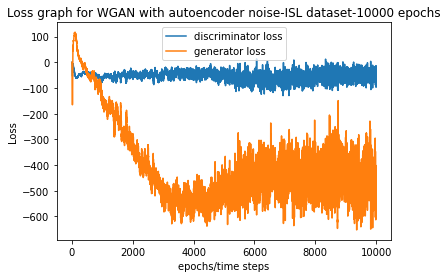

In [ ]:
import matplotlib.pyplot as plt
plt.plot(disc_loss,label='discriminator loss')
plt.plot(gen_loss,label='generator loss')
plt.xlabel('epochs/time steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for WGAN with autoencoder noise-ISL dataset-10000 epochs')
plt.show()

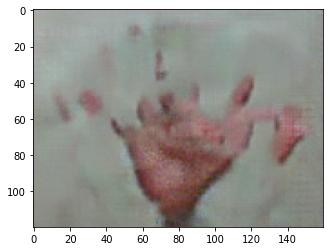

In [ ]:
#Generating random image
from numpy.random import randn
gm=load_model('drive/MyDrive/wgenerator_autoencode_model_test_ISL.h5')
idn=np.random.randint(0,X_train_noise.shape[0],1)
vector=X_train_noise[idn]
image=gm.predict(vector)
image=image*0.5+0.5
plt.imshow(image[0,:,:,:])